<a href="https://colab.research.google.com/github/sitnikovGOSHA/big_data_project/blob/main/%D0%98%D0%BD%D0%B4%D0%B8%D0%B2%D0%B8%D0%B4%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B8%CC%86_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%91%D0%9E%D0%9B%D0%AC%D0%A8%D0%98%D0%95_%D0%94%D0%90%D0%9D%D0%9D%D0%AB%D0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas matplotlib seaborn textblob requests

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-27-07a955daab2a>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Platform', y='Rating', data=df, ax=axes[0, 0], palette='viridis')
<ipython-input-27-07a955daab2a>:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Platform', y='Sentiment', data=df, ax=axes[0, 1], palette='viridis')
<ipython-input-27-07a955daab2a>:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Platform', y='Votes', data=df, ax=axes[1, 0], palette='viridis')
<ipython-input-27-07a955daab2a>:119: FutureWarning: 

Passing `palette` without assigning

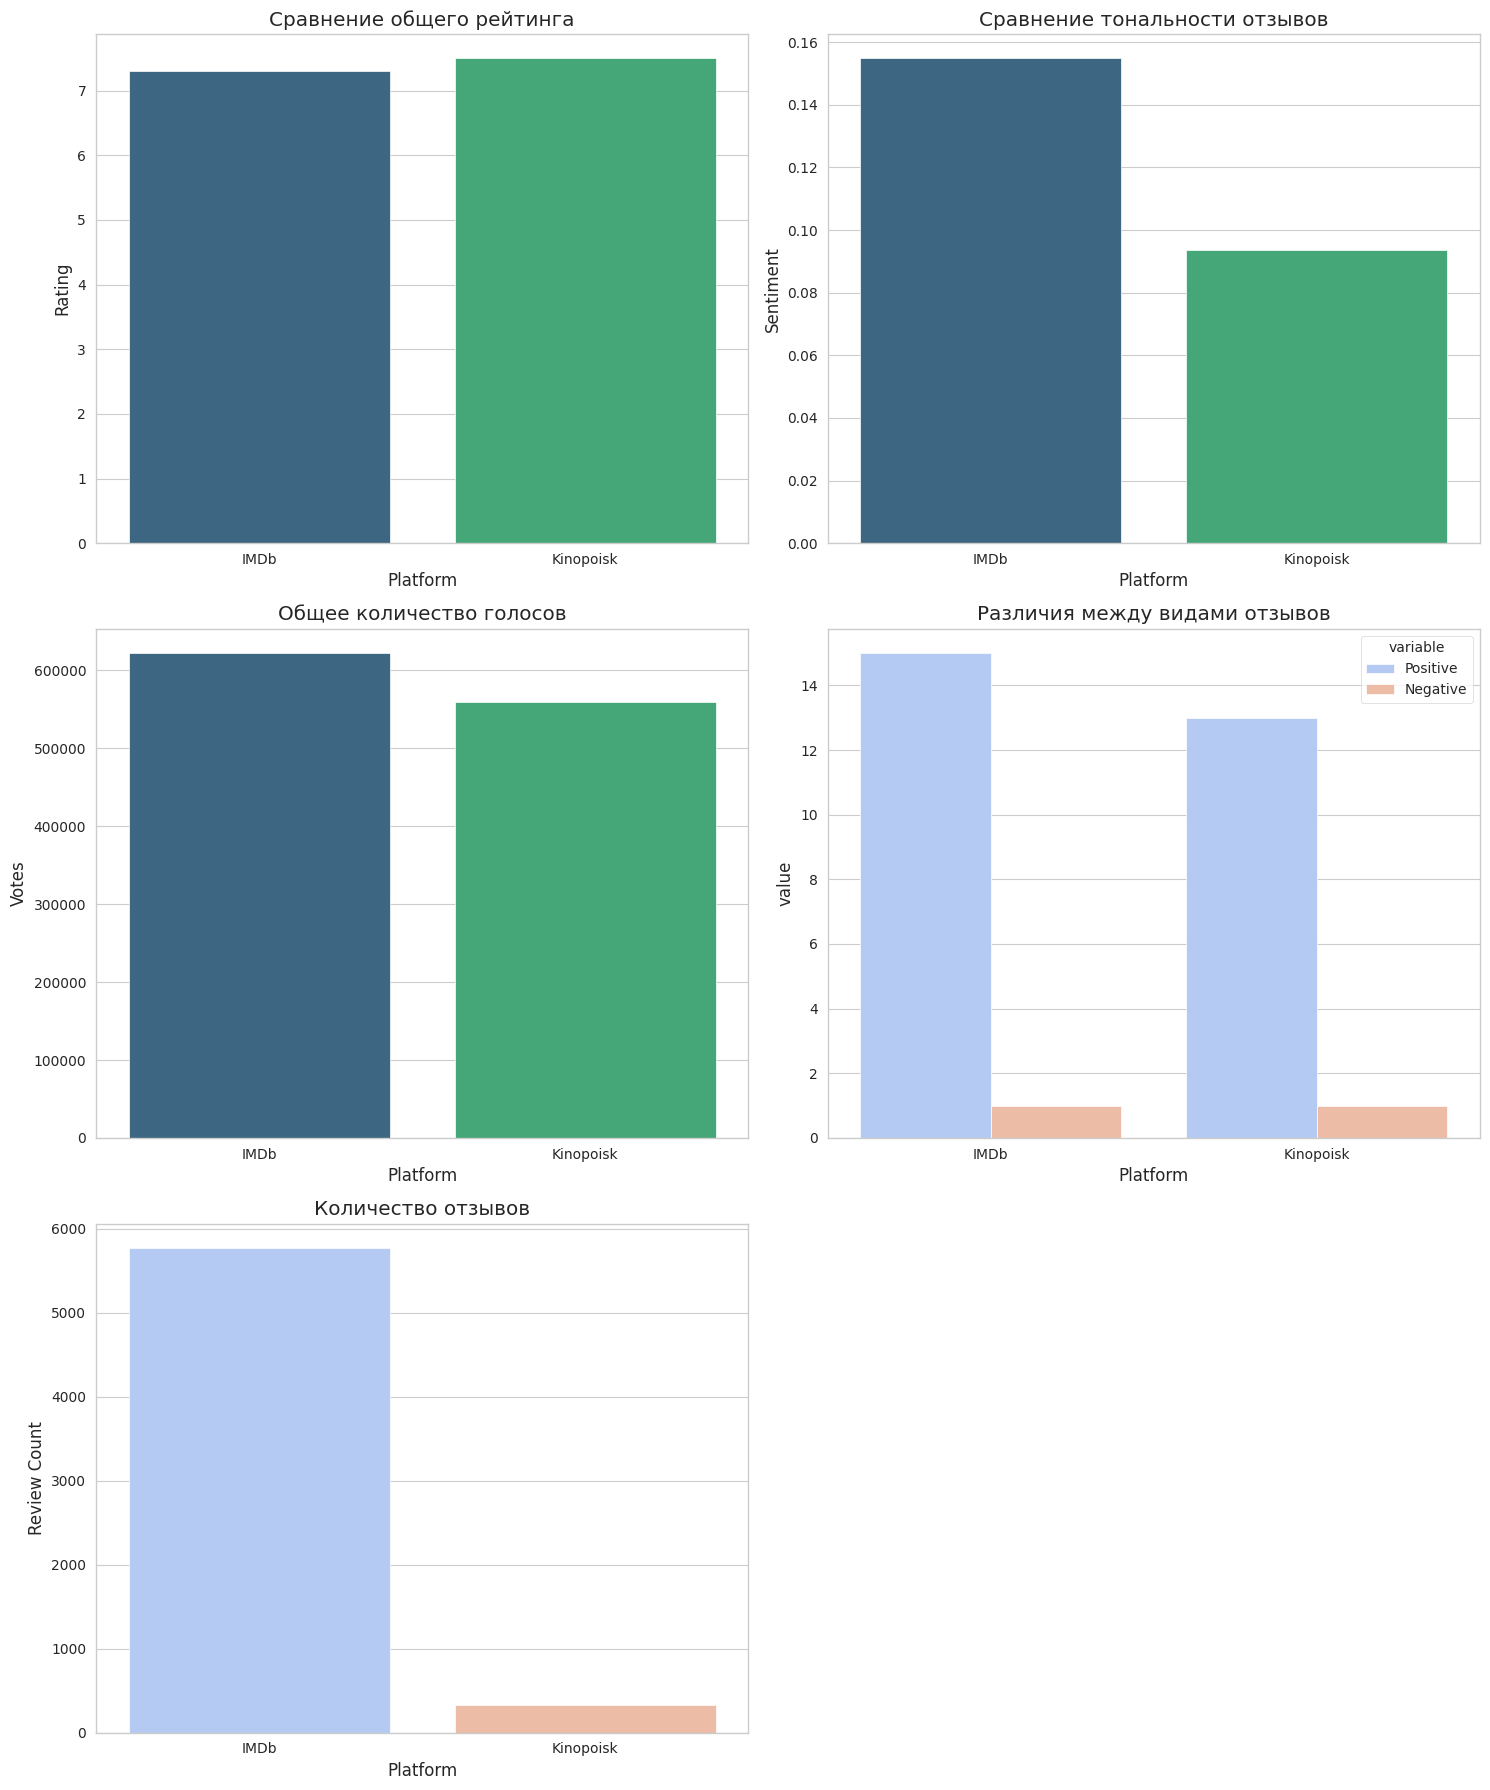


Результаты анализа:
    Platform  Rating   Votes  Positive  Negative  Sentiment  Review Count
0       IMDb     7.3  622293        15         1   0.154880          5776
1  Kinopoisk     7.5  559387        13         1   0.093507           331


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
import requests

!git clone https://github.com/sitnikovGOSHA/big_data_project.git


# Настройки
plt.style.use('ggplot')
sns.set_style("whitegrid")

def get_imdb_rating(movie_title, api_key="9038d016"):
    """Получение рейтинга IMDb через OMDb API"""
    try:
        url = f"http://www.omdbapi.com/?t={movie_title}&apikey={api_key}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()

        if data.get("Response") == "True":
            rating = float(data.get("imdbRating", 0)) if data.get("imdbRating", "N/A") != "N/A" else None
            votes = data.get("imdbVotes", "0").replace(",", "")
            return rating, int(votes) if votes.isdigit() else 0
        return None, None
    except Exception as e:
        print(f"Ошибка при запросе к OMDb API: {e}")
        return None, None

def load_reviews(filename):
    """Загрузка и очистка отзывов"""
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            reviews = []
            for line in f:
                line = line.strip()
                if not line:
                    continue

                # Очистка текста:
                line = re.sub(r'<[^>]+>', '', line)  # Удаление HTML-тегов
                line = re.sub(r'[^\w\s.,!?]', '', line)  # Удаление спецсимволов (кроме пунктуации)
                line = re.sub(r'\s+', ' ', line).strip()  # Удаление лишних пробелов

                reviews.append(line)

            # Удаление дубликатов (опционально)
            reviews = list(set(reviews)) if reviews else []
            return reviews
    except Exception as e:
        print(f"Ошибка загрузки {filename}: {e}")
        return []

def analyze_reviews(reviews):
# Анализ тональности отзывов
    if not reviews:
        return {'mean': 0, 'positive': 0, 'negative': 0, 'count': 0}

    sentiments = []
    pos = neg = 0

    for review in reviews:
        try:
            blob = TextBlob(review)  # Создание объекта TextBlob из текста отзыва
            polarity = blob.sentiment.polarity  # Получение оценки тональности отзыва
            sentiments.append(polarity)  # Добавление оценки тональности в список
            if polarity > 0.1: pos += 1  # Увеличение счетчика положительных отзывов
            elif polarity < -0.1: neg += 1  # Увеличение счетчика отрицательных отзывов
        except:
            continue #Продолжаем, если возникла ошибка в анализе конкретного отзыва

    return {
        'mean': np.mean(sentiments) if sentiments else 0,  # Вычисление среднего значения тональности
        'positive': pos,  # Количество положительных отзывов
        'negative': neg,  # Количество отрицательных отзывов
    }
#Нейтральные отзывы, где TextBlob не обнаружил тональность выше 0,1 или ниже - 0,1 не учитываются

def visualize_results(imdb_data, kp_data, imdb_rating, kp_rating, imdb_votes, kp_votes,
                      imdb_review_count, kp_review_count):
    """Визуализация сравнения"""
    data = {
        'Platform': ['IMDb', 'Kinopoisk'],
        'Rating': [imdb_rating, kp_rating],
        'Votes': [imdb_votes, kp_votes],
        'Positive': [imdb_data['positive'], kp_data['positive']],
        'Negative': [imdb_data['negative'], kp_data['negative']],
        'Sentiment': [imdb_data['mean'], kp_data['mean']],
        'Review Count': [imdb_review_count, kp_review_count]
    }

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    # График 1: Рейтинги
    sns.barplot(x='Platform', y='Rating', data=df, ax=axes[0, 0], palette='viridis')
    axes[0, 0].set_title('Сравнение общего рейтинга')

    # График 2: Тональность
    sns.barplot(x='Platform', y='Sentiment', data=df, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Сравнение тональности отзывов')

    # График 3: Оценки
    sns.barplot(x='Platform', y='Votes', data=df, ax=axes[1, 0], palette='viridis')
    axes[1, 0].set_title('Общее количество голосов')
    axes[1, 0].ticklabel_format(style='plain', axis='y')

    # График 4: Распределение отзывов
    df_melt = df.melt(id_vars=['Platform'], value_vars=['Positive', 'Negative'])
    sns.barplot(x='Platform', y='value', hue='variable', data=df_melt, ax=axes[1, 1], palette='coolwarm')
    axes[1, 1].set_title('Различия между видами отзывов')

    # График 5: Количество отзывов
    sns.barplot(x='Platform', y='Review Count', data=df, ax=axes[2,0], palette='coolwarm')
    axes[2,0].set_title('Количество отзывов')
    axes[2,1].remove()


    plt.tight_layout()
    plt.show()
    return df

def main():
    # Данные Кинопоиска
    kp_rating = 7.5
    kp_votes = 559387
    kp_review_count = 331  # Количество отзывов на Кинопоиске
    kp_reviews_file = "/content/big_data_project/kinopoisk_reviews.txt"  # Укажите имя файла с отзывами Кинопоиска

    # Данные IMDb
    movie_title = "Tenet"
    imdb_rating, imdb_votes = get_imdb_rating(movie_title)
    imdb_review_count = 5776  # Количество отзывов на IMDb
    imdb_reviews_file = "/content/big_data_project/imdb_reviews.txt" # Укажите имя файла с отзывами IMDb

    if imdb_rating is None:
        print("Не удалось получить данные IMDb. Выход.")
        return

    # Загрузка отзывов
    kp_reviews = load_reviews(kp_reviews_file)
    imdb_reviews = load_reviews(imdb_reviews_file)

    if not kp_reviews or not imdb_reviews:
        print("Не удалось загрузить отзывы с одной из платформ. Выход.")
        return

    # Анализ тональности отзывов
    kp_data = analyze_reviews(kp_reviews)
    imdb_data = analyze_reviews(imdb_reviews) # Анализируем отзывы с IMDb

    # Визуализация результатов
    df = visualize_results(imdb_data, kp_data, imdb_rating, kp_rating, imdb_votes, kp_votes, imdb_review_count, kp_review_count) # Передаем количество отзывов

    print("\nРезультаты анализа:")
    print(df)

if __name__ == "__main__":
    main()
